In [1]:
#generic imports
import os
import pathlib
import random
from datetime import datetime
import time
import numpy as np
import pandas as pd
import math
import argparse
import itertools
import os.path

#import constants
from epi_to_express.constants import (
    CHROM_LEN, 
    CHROMOSOMES, 
    SAMPLES,
    SAMPLE_IDS,
    CHROMOSOME_DATA,
    SRC_PATH,
    ASSAYS,
    PROJECT_PATH)

#model imports
import tensorflow as tf
#data loading imports
from epi_to_express.utils import Roadmap3D_tf
from epi_to_express.model import conv_profile_task_base
from epi_to_express.model import covnet
from epi_to_express.utils import pearsonR

2022-12-21 17:39:15.899834: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-21 17:39:15.899867: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# 1. --- SETUP PARAMETERS ------------------------------------------------
#paths
SAVE_PATH = pathlib.Path("./model_results")
MOD_SAVE_PATH = pathlib.Path("./model_results/models")
PRED_PATH = pathlib.Path("./model_results/predictions")
PRED_PATH.mkdir(parents=True, exist_ok=True)

#params
pred_resolution = 100# choice of 100, 500, 2000
# 1 Mb of the assay will be considered for the prediction of gene expression
window_size = 6_000
#number of k-fold cross validation
k_fold = 4
#seed
seed = 123
#regression problem
y_type = 'log2RPKM'

# Model specifics - similar to https://www.nature.com/articles/s42256-022-00570-9
batch_size = 64
n_epochs = 100
init_learning_rate = 0.001
lr_decay_factor = 0.2
lr_patience = 3
es_patience = 12
pool_factor=4
kernel_size_factor=3

In [3]:
loss_fn = pearsonR()#tf.keras.losses.mse
losses = []
indic = 0
for assay_i in ASSAYS:
    print(assay_i)
    for cell_i in SAMPLE_IDS:
        print(cell_i)
        print("K fold:")
        # 2. --- Dataset parameters -------------------------------
        #use k-fold cross-validation to retrain each model k times and hold out 
        train_dir = PROJECT_PATH/'chromoformer'/'preprocessing'
        train_meta = train_dir / 'train.csv'
        meta = pd.read_csv(train_meta) \
            .sample(frac=1, random_state=seed) \
            .reset_index(drop=True) # load and shuffle.

        #filter metadat to cell type of interest
        meta = meta[meta.eid == cell_i]

        # Split genes into two sets (train/val).
        genes = set(meta.gene_id.unique())
        n_genes = len(genes)
        #get data for folds separated
        qs = [
            meta[meta.split == 1].gene_id.tolist(),
            meta[meta.split == 2].gene_id.tolist(),
            meta[meta.split == 3].gene_id.tolist(),
            meta[meta.split == 4].gene_id.tolist(),
        ]
        #loop through folds
        for ind,fold in enumerate([x+1 for x in range(k_fold)]):
            print(fold)
            #get fold specific data ----
            train_genes = qs[(fold + 0) % 4] + qs[(fold + 1) % 4] + qs[(fold + 2) % 4]
            val_genes = qs[(fold + 3) % 4]

            #split val_genes in two to get validation and test set
            # train/val split by chrom so do the same for val test
            val_test_genes = val_genes
            val_test_chrom = list(set(meta[meta.gene_id.isin(val_test_genes)]['chrom']))
            val_chrom = val_test_chrom[0:len(val_test_chrom)//2]
            test_chrom = val_test_chrom[len(val_test_chrom)//2:len(val_test_chrom)]
            val_genes = meta[meta.gene_id.isin(val_test_genes) & meta.chrom.isin(val_chrom)]['gene_id'].tolist()
            test_genes = meta[meta.gene_id.isin(val_test_genes) & meta.chrom.isin(test_chrom)]['gene_id'].tolist()
            #----
            #data loaders ----
            test_generator = Roadmap3D_tf(cell_i, test_genes, batch_size=batch_size,
                                          w_prom=window_size, w_max=window_size,
                                          marks = [assay_i],y_type=y_type,
                                          pred_res = pred_resolution,
                                          return_pcres=False)
            
            #get model
            mod_pth = f"{MOD_SAVE_PATH}/covnet_{cell_i}_{'-'.join([assay_i])}_kfold{fold}"
            model = tf.keras.models.load_model(mod_pth, custom_objects={'pearsonR': pearsonR})
            #compile
            model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=init_learning_rate),
                          loss=tf.keras.losses.mean_squared_error,
                          metrics=['mse',pearsonR()])
            scores = []
            for ind in range(len(test_generator)):
                #get data
                X,y = test_generator[ind]
                #predict
                output = model.predict(X)
                #eval
                evalu = loss_fn(y, output)
                scores.append(evalu)
            #keep all res in a list index is assay-cell
            scores = [score.numpy() for score in scores]
            losses.append(pd.DataFrame({"assay":[assay_i]*len(scores),
                                        "cell":[cell_i]*len(scores),
                                        "Pearson_R":scores}))

2022-12-21 17:39:17.551770: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-12-21 17:39:17.551806: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (workstation-neurogenomics): /proc/driver/nvidia/version does not exist
2022-12-21 17:39:17.552439: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


h3k4me1
E003
K fold:
1
2
3
4
E004
K fold:
1
2
3
4
E005
K fold:
1
2
3
4
E006
K fold:
1
2
3
4
E007
K fold:
1
2
3
4
E016
K fold:
1
2
3
4
E066
K fold:
1
2
3
4
E087
K fold:
1
2
3
4
E114
K fold:
1
2
3
4
E116
K fold:
1
2
3
4
E118
K fold:
1
2
3
4
h3k4me3
E003
K fold:
1
2
3
4
E004
K fold:
1
2
3
4
E005
K fold:
1
2
3
4
E006
K fold:
1
2
3
4
E007
K fold:
1
2
3
4
E016
K fold:
1
2
3
4
E066
K fold:
1
2
3
4
E087
K fold:
1
2
3
4
E114
K fold:
1
2
3
4
E116
K fold:
1
2
3
4
E118
K fold:
1
2
3
4
h3k9me3
E003
K fold:
1
2
3
4
E004
K fold:
1
2
3
4
E005
K fold:
1
2
3
4
E006
K fold:
1
2
3
4
E007
K fold:
1
2
3
4
E016
K fold:
1
2
3
4
E066
K fold:
1
2
3
4
E087
K fold:
1
2
3
4
E114
K fold:
1
2
3
4
E116
K fold:
1
2
3
4
E118
K fold:
1
2
3
4
h3k27me3
E003
K fold:
1
2
3
4
E004
K fold:
1
2
3
4
E005
K fold:
1
2
3
4
E006
K fold:
1
2
3
4
E007
K fold:
1
2
3
4
E016
K fold:
1
2
3
4
E066
K fold:
1
2
3
4
E087
K fold:
1
2
3
4
E114
K fold:
1
2
3
4
E116
K fold:
1
2
3
4
E118
K fold:
1
2
3
4
h3k36me3
E003
K fold:
1
2
3
4
E004
K fold:


In [4]:
#concat to single dataframe
losses = pd.concat(losses)
#save res
losses.to_csv(f"{PRED_PATH}/blind_test.csv", sep='\t',index=False)

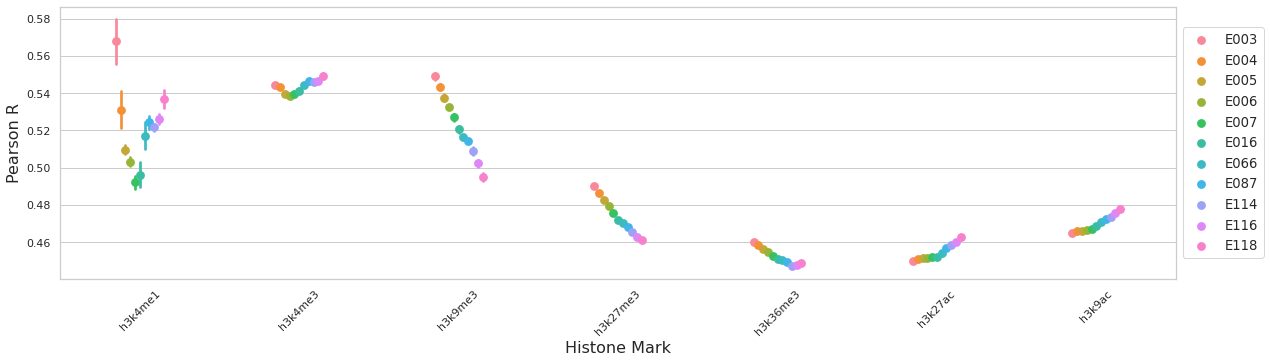

In [8]:
#plot
import seaborn as sns
sns.set(rc={'figure.figsize':(20, 5)})
#sns.set_palette("colorblind")
#same wesanderson palette as used in R plots
extended_palette = ["#9A8822","#F5CDB4","#F8AFA8",
                    "#FDDDA0","#74A089","#85D4E3",
                    #added extra to make 7
                    '#78A2CC']
sns.set(font_scale = 1.2)
sns.set_style("whitegrid")

perf_plt = sns.pointplot(hue = "cell",       
            y = "Pearson_R",
            x = "assay",  
            #palette=sns.color_palette(extended_palette, 7)[2:4],
            data = losses, ci="sd",join=False,
            dodge=0.3
                      )
#perf_plt.set_title('MSE',fontsize=14)
#perf_plt.legend([],[], frameon=False)
# Put the legend out of the figure
perf_plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#perf_plt.set(ylim=(-.1, .9))
perf_plt.tick_params(axis='x', rotation=45)

perf_plt.set_xlabel('Histone Mark',fontsize=16)
perf_plt.set_ylabel('Pearson R',fontsize=16)
perf_plt.tick_params(labelsize=11)

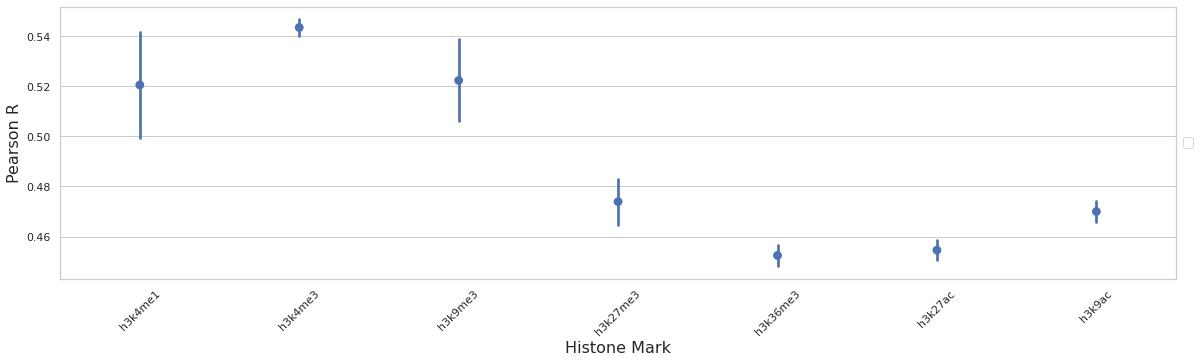

In [12]:
#plot
import seaborn as sns
sns.set(rc={'figure.figsize':(20, 5)})
#sns.set_palette("colorblind")
#same wesanderson palette as used in R plots
extended_palette = ["#9A8822","#F5CDB4","#F8AFA8",
                    "#FDDDA0","#74A089","#85D4E3",
                    #added extra to make 7
                    '#78A2CC']
sns.set(font_scale = 1.2)
sns.set_style("whitegrid")

perf_plt = sns.pointplot(       
            y = "Pearson_R",
            x = "assay",  
            #palette=sns.color_palette(extended_palette, 7)[2:4],
            data = losses, ci="sd",join=False,
            dodge=0.3
                      )
#perf_plt.set_title('MSE',fontsize=14)
#perf_plt.legend([],[], frameon=False)
# Put the legend out of the figure
perf_plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
perf_plt.tick_params(axis='x', rotation=45)

perf_plt.set_xlabel('Histone Mark',fontsize=16)
perf_plt.set_ylabel('Pearson R',fontsize=16)
perf_plt.tick_params(labelsize=11)

In [ ]:
#1. h3k4me3 - indicative of a promoter region [_11_](https://science.sciencemag.org/content/366/6469/1134.full#ref-11)
#2. h3k9me3 - associated with heterochromatin?
#3. h3k4me1 - commonly associated with distal enhancers (https://www.frontiersin.org/articles/10.3389/fcell.2020.00289/full)
#then rest
#   h3k27me3 - repressive mark
#   h3k9ac - associated with active promoters (https://bmcgenomics.biomedcentral.com/articles/10.1186/1471-2164-13-424)
#   h3k27ac - active enhancers and promoters (?) (https://www.frontiersin.org/articles/10.3389/fgene.2020.00817/full)
#   h3k36me3 - heterochromatin (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3166828/)

Other papers tried to study this using SVMs and linear regression (they had a lot of limitations like only considering 1 or 2 cell types) but [one used linear regression](https://www.pnas.org/doi/10.1073/pnas.0909344107#:~:text=Histone%20Modification%20Levels%20Are%20Predictive%20of%20Gene%20Expression%20Across%20Different,within%20a%20given%20cell%20type.) did also find H3K4me3 to be fairly predictive. Also [this paper](https://www.nature.com/articles/s41588-022-01026-x/figures/1) we had in journal club, which predicts histone marks from expression also had some of the highest scores in H3K4me3, although it did also have h3k9ac which I found did poorly (again less cells types and different data)

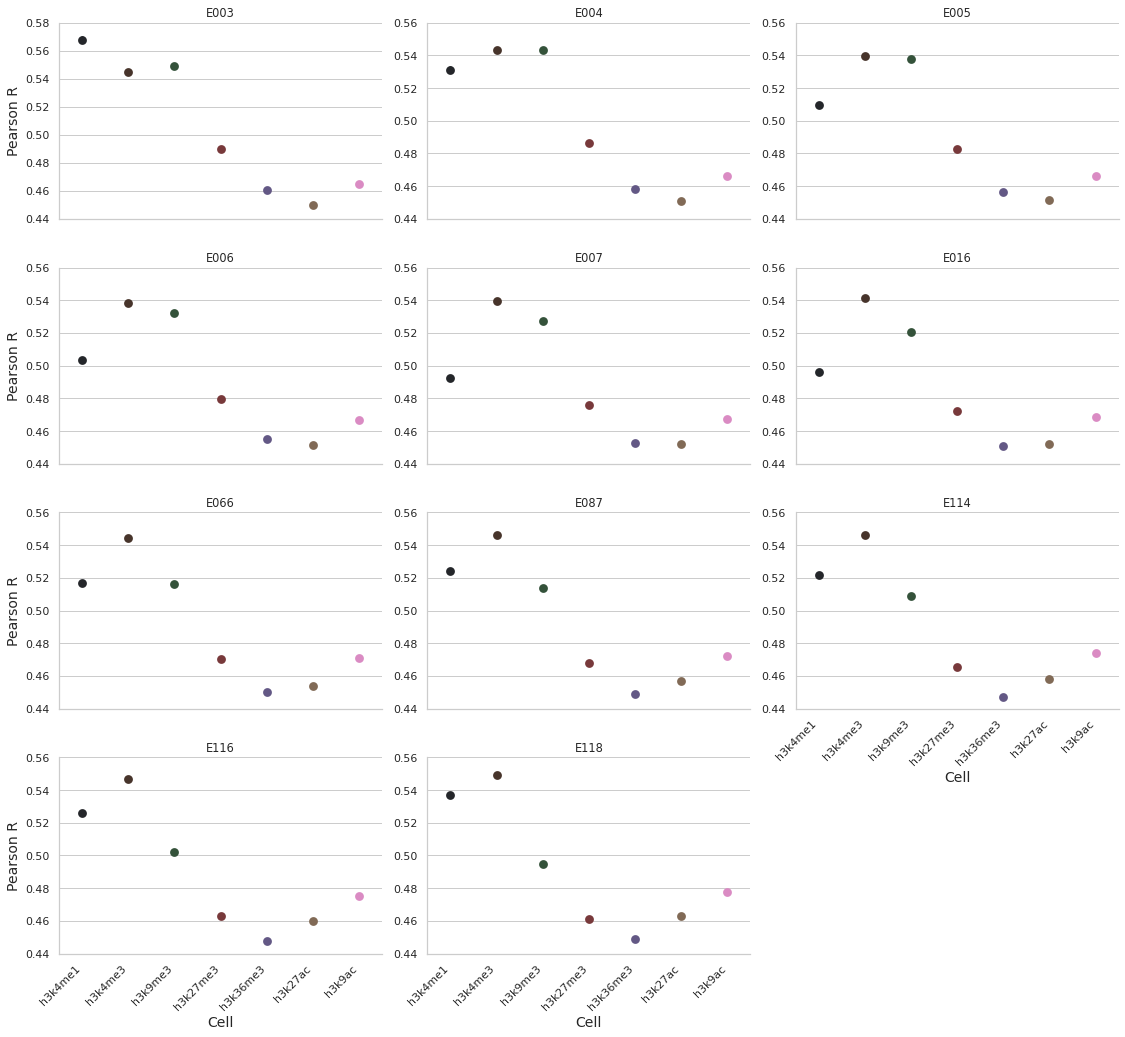

In [7]:
#plot
import seaborn as sns
sns.set(rc={'figure.figsize':(20, 5)})
sns.set_palette("colorblind")
sns.set(font_scale = 0.95)
sns.set_style("whitegrid")

perf_plt = sns.FacetGrid(losses, col = "cell", hue="assay",col_wrap=3,
                         sharey=False, sharex=True, margin_titles=True,
                         height=3.5, aspect=1.5)
perf_plt = perf_plt.map(sns.pointplot,"assay","Pearson_R","assay",
                        order=losses['assay'].explode().unique(),
                        hue_order=losses['assay'].explode().unique())
                        #ci="sd",join=False,dodge=0.3)
#perf_plt.set_title('MSE',fontsize=14)
#perf_plt.legend([],[], frameon=False)
# Put the legend out of the figure
#perf_plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#perf_plt.set(ylim=(-.1, .9))
perf_plt.set_xticklabels(rotation=45,fontsize=11,ha='right')
perf_plt.set_yticklabels(fontsize=11)
perf_plt.set_titles(col_template="{col_name}")

perf_plt.set_axis_labels(x_var='Cell', y_var='Pearson R',fontsize=14)
#perf_plt.tick_params(labelsize=11)